In [32]:

import mne_nirs
import mne
from mne_bids import BIDSPath, get_entity_vals
from mne.preprocessing.nirs import optical_density, temporal_derivative_distribution_repair
from itertools import compress
import numpy as np
import matplotlib.pyplot as plt

## Load the data


In [33]:
def epoch_preprocessing(subject_index, t_min,t_max):
    
    """
    Arguments:
    Subject index: int = Index of the subject to be processed [0, 1, 2, 3, 4, 5, 6, 7]
    t_min: float =  Time to initialize the epoch
    t_max: float = Time to end the epoch
    
    Returns:
    haemo:= The preprocessed haemoglobin data
    epochs: mne.Epochs object = The preprocessed epochs. You can use this to get the data and labels for the classification task.
    X: np.array = The preprocessed data. Shape: (n_trials, n_channels, n_times)
    Y: np.array = The labels for the classification task. Shape: (n_trials,)
    Y labels : 1.0-> Audio, 3.0 -> Control (Silence)
    """
    
    root = mne_nirs.datasets.audio_or_visual_speech.data_path()
    
    print(root)
    
    subject= get_entity_vals(root, "subject")[subject_index]
   
        
    dataset = BIDSPath(
            root=root,
            suffix="nirs",
            extension=".snirf",
            subject=subject,
            task="AudioVisualBroadVsRestricted",
            datatype="nirs",
            session="01"
                            )
                
    #Raw intensity data
    raw_intensity = mne.io.read_raw_snirf(dataset.fpath)
    
    raw_intensity.annotations.rename(
        {"1.0": "Audio", "2.0": "Video", "3.0": "Control", "15.0": "Ends"}
    )
    
    
    # Converting raw intensity to optical density
    raw_od = optical_density(raw_intensity)


    #Compute scalp coupling index to identify optodes that were not well attached to the scalp
    #Rejection criterion of < 0.8
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.8))
    
    print("Number of channels before removing bad channels: ", len(raw_od.ch_names))
    #raw_od = raw_od.info.pop('bads')

    raw_od = raw_od.drop_channels(raw_od.info['bads'])

    print("Number of channels after removing bad channels: ", len(raw_od.ch_names))
        

    #Temporal Derivative Distribution Repair
    
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    
    #Apply short channel correction  to remove the influence from non-cortical changes in blood oxygenation.
    
    # A short separation channels measures solely the extracerebral signals, which includes 
    # blood presure waves, mayer waves, respiration and cardiac cycles.
    # The signal components od the short separation channel can be seen as the noise in the signal of the 
    # long channel.BY removing these components from the log channel, you cna minimize the noise.
    
    
    od_corrected = mne_nirs.signal_enhancement.short_channel_regression(corrected_tddr)
    #Convert optical density to haemoglobin concentration using the Beer-Lambert Law
    haemo = mne.preprocessing.nirs.beer_lambert_law(od_corrected, ppf=6)
    
    haemo = mne_nirs.channels.get_long_channels(haemo)
    
    #Bandpass filter the haemoglobin data between 0.02 and 0.4 Hz
    #to removoe slow drifts and components related to the heart rate
    haemo = haemo.filter(0.02,0.4)
    
    #Signal enhancement method (negative correlation enhancement algorithm) Cui et. al. 2010
    
    haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(haemo)
    

        
    events, event_dict = mne.events_from_annotations(haemo)
    
    #An epoch rejection criterion  was employed to exclude epochs with a signal amplitude > 100 uM
    epochs = mne.Epochs(
        haemo,
        events,
        event_id=event_dict,
        tmin=t_min,
        tmax=t_max,
        reject=dict(hbo=100e-6, hbr=100e-6), # Epoc rejection criterion
        reject_by_annotation=True,
        proj=False,
        baseline=None,
        detrend=None,
        preload=True,
        verbose=True,
    )
    
    # I am just selecting the Audio and Control epochs
    epochs = epochs[["Audio", "Control"]]
    
    return haemo, epochs

In [34]:
def audio_data(subject_index, t_min, t_max):
    """
    Arguments:
    subject_index: int = Index of the subject to be processed [0, 1, 2, 3, 4, 5, 6, 7]
    t_min: float =  Time to initialize the epoch
    t_max: float = Time to end the epoch
    
    Returns:
    
    X: np.array = The preprocessed data. Shape: (n_trials, n_channels, n_times)
    Y: np.array = The labels for the classification task. Shape: (n_trials,)
    Y labels : 1.0-> Audio, 3.0 -> Control (Silence)
    """
    
    haemo, epochs = epoch_preprocessing(subject_index, t_min, t_max)
    
    X = epochs.get_data()
    Y = epochs.events[:, 2]
    print("Shape of the data: ", X.shape)
    print("Shape of the labels: ", Y.shape)

    # Change the labels to 0 and 1
    Y = (Y == 1).astype(int)

    return X, Y
    

## Train function 

In [35]:

import pandas as pd 
import os

from sklearn.model_selection import (KFold, StratifiedKFold, StratifiedGroupKFold,
                                     GridSearchCV, train_test_split)

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours

import seaborn as sns
from sklearn.metrics import roc_auc_score

In [36]:
def machine_learning_exp(model,X,Y,output_folder,dataset,sampling):
    
    """
    Function train SVM, LDA and KNN models with nested cross-validation.
    
    The outer cross-validation  with 5 folds is used to evaluate the model performance, while the inner 
    cross-validation with 3 folds is used to tune the hyperparameters.
    
    Parameters
    ----------
    model : str
        The model to be used. Can be 'svc', 'lda' or 'knn'.
    X : np.array
        The features to be used for training and testing the model. shape (n_trials, n_channels, n_timepoints)
    Y : np.array
        The labels to be used for training and testing the model.
    output_folder : str
        The folder where the results will be saved.
    dataset : str
        The name of the dataset. Can be 'audio_study'. 
        
    sampling : str
        The sampling method to be used. Can be 'Random_over', 'SMOTE', 'ADASYN', 'BorderlineSmote', 
        'Random_under'
        
    Returns
    -------
    accuracies : list
        The accuracies of the model on the test sets.
    all_hps : list
        The best hyperparameters of the model on the test sets.
    auc : list
        The AUC of the model on the test sets.
    svc_coeff : list
        The coefficients of the learned features from the SVC model or LDA model
    
    """
    

    # outer and inner cross-validation parameters
    OUTER_K = 5
    INNER_K = 3
    SEED = 22

    # Standard machine learning parameters
    MAX_ITER = 250000  # for support vector classifier
    
    # Regularization parameters values tested for the SVC
    C_LIST = [1e-3, 1e-2, 1e-1, 1e0]
    # Number of neighbors values tested for the KNN
    N_NEIGHBORS_LIST = list(range(1, 10))


    all_y_true = []
    all_y_pred = []
    accuracies = []
    additional_metrics = []
    all_hps = []
    auc = []
    
    svc_coeff =[]
    lda_coeff = []

    out_kf = StratifiedKFold(n_splits=OUTER_K,shuffle=True,random_state=SEED)
    in_kf = StratifiedKFold(n_splits=INNER_K,shuffle=True,random_state=SEED)

    out_split = out_kf.split(X, Y)

    for k, out_idx in enumerate(out_split):
        
        print(f'Outer fold {k+1}/{OUTER_K}')
        X_train, X_test = X[out_idx[0]], X[out_idx[1]]
        Y_train, Y_test = Y[out_idx[0]], Y[out_idx[1]]
        
        X_train, Y_train = shuffle(X_train, Y_train, random_state=SEED)
        
        all_y_true.extend(Y_test)
        
        
        #Normalize 
        
        maxs = X_train.max(axis =(0,2),keepdims=True)
        mins = X_train.min(axis =(0,2),keepdims=True)
        
        X_train = (X_train - mins)/(maxs-mins)
        X_test = (X_test - mins)/(maxs-mins)
        
        X_train = X_train.reshape(X_train.shape[0],-1)
        X_test = X_test.reshape(X_test.shape[0],-1)
        
        
        if dataset =='audio_study':
    
        
            if sampling == 'Random_over':
                
                print("Random Oversampling")
                
                ros = RandomOverSampler(random_state=SEED)
                X_train,Y_train = ros.fit_resample(X_train, Y_train)
                
            elif sampling == 'SMOTE':
                
                print("Smote Oversampling")
                
                X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
                
            elif sampling == 'ADASYN':
                
                print("ADASYN Oversampling")
                
                X_train, Y_train = ADASYN().fit_resample(X_train,Y_train)
                
            elif sampling =='BorderlineSmote':
                
                print("BorderlineSmote Oversampling")
                
                X_train, Y_train = BorderlineSMOTE.fit_resample(X_train,Y_train)
                
            elif sampling=='Random_under':
                
                print("Random Undersampling")
                
                rus = RandomUnderSampler(random_state=SEED)
                
                X_train, Y_train = rus.fit_resample(X_train,Y_train)
                
            elif sampling == 'EditedNearesNeighbours':
                
                print("Edited Nearest Neighbours undersampling")
                
                enn = EditedNearestNeighbours()
                
                X_train, Y_train = enn.fit_resample(X_train,Y_train)
                
            elif sampling == 'No':
                
                print("No sampling method applied")
                
                X_train,Y_train = X_train, Y_train

        # Inner CV
        
        in_split = in_kf.split(X_train, Y_train)
        
        if model == 'lda':
            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, Y_train)
            lda_coeff.append(lda.coef_)
            y_pred = lda.predict(X_test).tolist()
            all_hps.append(None)
            
        elif model=='knn':
            parameters = {'n_neighbors': N_NEIGHBORS_LIST}
            knn = KNeighborsClassifier()
            clf = GridSearchCV(knn, parameters,scoring = 'accuracy', cv=in_split)
            clf.fit(X_train,Y_train)
            y_pred = clf.predict(X_test).tolist()
            
            all_hps.append(clf.best_params_['n_neighbors'])
            
        elif model=='svc':
            parameters = {'C': C_LIST}
            svc = LinearSVC(max_iter=MAX_ITER, dual='auto')
            clf = GridSearchCV(svc, parameters,scoring = 'accuracy', cv=in_split)
            clf.fit(X_train,Y_train)
            best_svc= clf.best_estimator_
            svc_coeff.append(best_svc.coef_)
            print("number of features seen during fit:", best_svc.n_features_in_)
            y_pred = clf.predict(X_test).tolist()
            
            all_hps.append(clf.best_params_['C'])
        
            
            
        # Metrics
        accuracies.append(accuracy_score(Y_test, y_pred))
        auc.append(roc_auc_score(Y_test, y_pred))
        prfs = precision_recall_fscore_support(Y_test, y_pred)
        additional_metrics.append(prfs)
        all_y_pred += y_pred
        

    # Figures
    cm = confusion_matrix(all_y_true, all_y_pred, normalize='true')
    sns.heatmap(cm, annot=True, cmap='crest', vmin=0.1, vmax=0.8)
    plt.xlabel('Predicted')
    plt.ylabel('Ground truth')
    plt.title('Confusion matrix on the test sets')
    plt.savefig(f'{output_folder}/confusion_matrix_{model}.png')
    plt.close()
    

    return accuracies, all_hps, auc,svc_coeff,lda_coeff

## Main cell to train models and save results

In [37]:
out_folder = os.path.join(os.getcwd(), '0_18')
os.makedirs(out_folder, exist_ok=True)
CONFIDENCE = 0.05  # stat confidence at 95 %

SEED = 22
sampling = 'ADASYN'

dict_accuracies = {}
subjects = [0]


t_min = 0.0 # ONSET
t_max = 18.0 # END

classes = 2



In [38]:
for subject in subjects:
    
    audio_folder = os.path.join(out_folder,f'_folder_subj_{subject}')
    os.makedirs(audio_folder, exist_ok=True)
    
    lda_coeff_path = os.path.join(out_folder,f'_lda_coeff_{subject}')
    os.makedirs(lda_coeff_path, exist_ok=True)
    
    DATASETS = {'audio_study': [t_min,t_max]}
    
    with open(f'{audio_folder}/summary_subj_{subject}.md', 'w') as w:
        w.write('# AUC table\n\n(Standard deviation on the cross-validation)')
        w.write('\n\n|Dataset|Chance level|')
        w.write('LDA (sd)|SVC (sd)|\n')
        w.write('|:---:|:---:|:---:|:---:|:---:|:---:|\n')
    with open(f'{audio_folder}/results_subj_{subject}.csv', 'w') as w:
        w.write('dataset;model;fold;AUC;hyperparameters\n')
        
    for dataset in DATASETS.keys():
        print(f'Processing {dataset} dataset')
        params = DATASETS[dataset]

        
        if dataset == 'audio_study':
            t_min, t_max = params

            X,Y= audio_data(subject,t_min,t_max)
            #X = X[:,:,int(3.9*abs(t_min)):]
            print("X shape", X.shape)
            
            

        _, hps_svc,svc,svc_coeff,_ = machine_learning_exp("svc",X,Y,audio_folder,dataset,sampling)
        _, hps_lda,lda,_,lda_coeff = machine_learning_exp("lda", X, Y, audio_folder,dataset,sampling)
        #_, hps_knn,knn,_,_= machine_learning_exp("knn", X, Y,audio_folder,dataset,sampling)
        
        
        #Saving the coefficients of the trained models
        np.savez(audio_folder, folder_1 = svc_coeff[0],folder_2 = svc_coeff[1],
                 folder_3 = svc_coeff[2], folder_4 = svc_coeff[3], folder_5= svc_coeff[4])
        
        np.savez(lda_coeff_path, folder_1 = lda_coeff[0],folder_2 = lda_coeff[1],
                 folder_3 = lda_coeff[2], folder_4 = lda_coeff[3], folder_5= lda_coeff[4])
    
        results = {'LDA': [lda, hps_lda], 'SVC': [svc, hps_svc]}
        
        chance_level = np.around(1/classes, decimals=3)
        w_summary = open(f'{audio_folder}/summary_subj_{subject}.md', 'a')
        w_results = open(f'{audio_folder}/results_subj_{subject}.csv', 'a')
        w_summary.write(f'|{dataset}|{chance_level}|')
        for model in results.keys():
            w_summary.write(
                f'{np.around(np.mean(results[model][0]), decimals=3)} '
                f'({np.around(np.std(results[model][0]), decimals=3)})|')
            for fold, auc in enumerate(results[model][0]):
                hps = results[model][1][fold]
                w_results.write(f'{dataset};{model};{fold+1};{auc};"{hps}"\n')
        w_summary.write('\n')
        w_summary.close()
        w_results.close()
        dict_accuracies[dataset] = lda + svc 

    dict_accuracies['Model'] = list(np.repeat(list(results.keys()), len(lda)))
    df_accuracies = pd.DataFrame(dict_accuracies)
    df_accuracies = df_accuracies.melt(
        id_vars=['Model'], value_vars=list(DATASETS.keys()),
        var_name='Dataset', value_name='AUC')
    plt.figure(figsize=(16, 6))
    sns.barplot(data=df_accuracies, y='AUC', x='Dataset', hue='Model',
                capsize=.1, palette='colorblind')
    plt.axhline(1/2, color='blue', linestyle=':', label='2 classes chance level')
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc=6)
    plt.savefig(f'{audio_folder}/summary.png', bbox_inches='tight', dpi=1200)
    plt.close()
    
   
    

Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-01/ses-01/nirs/sub-01_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf


Reading 0 ... 7976  =      0.000 ...  2041.856 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  90
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples (165.120 s)

Used Annotations descriptions: [np.str_('Audio'), np.str_('Control'), np.str_('Ends'), np.str_('Video')]
Not setting metadata
48 matching events found
No baseline correction applied
Using data from preloaded Raw for 48 events and 71 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


number of features seen during fit: 5396
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 3/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


number of features seen during fit: 5396
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling


## Results

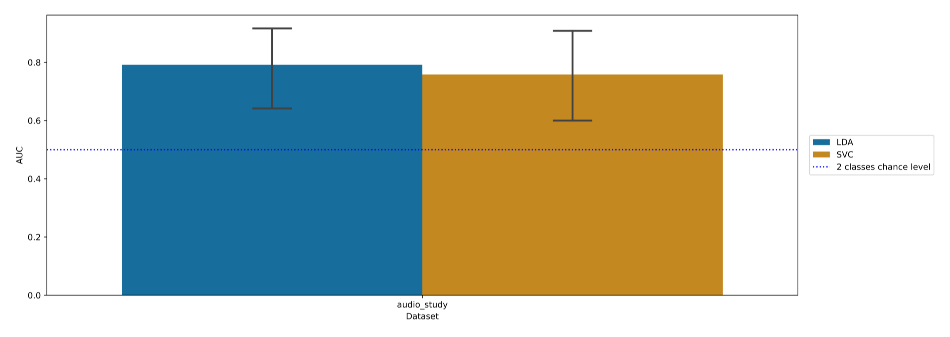

In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.imshow(mpimg.imread("0_18/_folder_subj_0/summary.png"))
plt.axis('off')
plt.show()


In [40]:
md_file_path = "0_18/_folder_subj_0/summary_subj_0.md"

# Open and read the file
with open(md_file_path, 'r') as file:
    md_content = file.read()

# Print the content
print(md_content)

# AUC table

(Standard deviation on the cross-validation)

|Dataset|Chance level|LDA (sd)|SVC (sd)|
|:---:|:---:|:---:|:---:|:---:|:---:|
|audio_study|0.5|0.792 (0.167)|0.758 (0.172)|



### Results from each outer cross-validation folder

In [42]:
import pandas as pd

cv = pd.read_csv("0_18/_folder_subj_0/results_subj_0.csv", sep=';')
print(cv)

       dataset model  fold       AUC  hyperparameters
0  audio_study   LDA     1  0.875000              NaN
1  audio_study   LDA     2  0.500000              NaN
2  audio_study   LDA     3  0.750000              NaN
3  audio_study   LDA     4  0.833333              NaN
4  audio_study   LDA     5  1.000000              NaN
5  audio_study   SVC     1  0.875000            0.100
6  audio_study   SVC     2  0.500000            0.010
7  audio_study   SVC     3  0.750000            0.001
8  audio_study   SVC     4  0.666667            0.010
9  audio_study   SVC     5  1.000000            0.100
